# Supervised Learning : NBA Shots Log Data (DS-SF-25 | Final Project)

This notebook is part of my final project for the General Assembly Part Time Data Science course. The project seeks to  to predict the results of field goal attempts in the 14-15 NBA regular season.

* Notebook below is the code for machine learning models, comparing training and testing results among different classification models.
* For the EDA notebook, please refer to:
* The data source for this project: https://www.kaggle.com/dansbecker/nba-shot-logs

## Importing and Reading Data

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import linear_model, metrics
from sklearn import neighbors, metrics, grid_search, cross_validation
from sklearn import tree, ensemble, metrics, cross_validation, externals
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

In [2]:
def read_dataset(x):
    return pd.read_csv(os.path.join('..', 'datasets', x))
train_2_df = read_dataset('train_2pts.csv')
test_2_df = read_dataset('test_2pts.csv')

In [3]:
# dropping the index from the from the prior data read for EDA purpose.
train_2_df = train_2_df.drop('Unnamed: 0',1)
test_2_df = test_2_df.drop('Unnamed: 0',1)

In [4]:
train_2_df.head(2)

,GAME_ID,MATCHUP,LOCATION,W,FINAL_MARGIN,SHOT_NUMBER,PERIOD,GAME_CLOCK,SHOT_CLOCK,DRIBBLES,...,PTS,player_name,player_id,Month,location_t,GAME_CLOCK_t,SHOT_CLOCK_t,Catch&Shot,SHOT_DISTANCE,CLOSEST_DEFENDER_DISTANE
0,21400530,"JAN 07, 2015 - DEN vs. ORL",H,W,3,7,3,9:51,8.6,0,...,2,jusuf nurkic,203994,JAN,0,2031.0,2,1,6,4
1,21400325,"DEC 10, 2014 - MIA @ DEN",A,L,-20,5,2,11:12,12.9,2,...,0,dwayne wade,2548,DEC,1,1392.0,3,0,8,2


In [5]:
# Correlation table for significant features
train_2_df[['SHOT_NUMBER','GAME_CLOCK_t','Catch&Shot','SHOT_CLOCK','SHOT_DIST','CLOSE_DEF_DIST','FGM']].corr()

,SHOT_NUMBER,GAME_CLOCK_t,Catch&Shot,SHOT_CLOCK,SHOT_DIST,CLOSE_DEF_DIST,FGM
SHOT_NUMBER,1.000000,0.583843,-0.081208,-0.039460,0.007986,-0.019974,-0.004529
GAME_CLOCK_t,0.583843,1.000000,-0.022117,-0.043919,-0.000534,-0.016598,-0.008079
Catch&Shot,-0.081208,-0.022117,1.000000,0.170867,-0.031228,0.154217,0.094551
SHOT_CLOCK,-0.039460,-0.043919,0.170867,1.000000,-0.247157,0.014916,0.116830
SHOT_DIST,0.007986,-0.000534,-0.031228,-0.247157,1.000000,0.461443,-0.168766
CLOSE_DEF_DIST,-0.019974,-0.016598,0.154217,0.014916,0.461443,1.000000,0.051432
FGM,-0.004529,-0.008079,0.094551,0.116830,-0.168766,0.051432,1.000000


In [6]:
corr=train_2_df[['SHOT_NUMBER','GAME_CLOCK_t','Catch&Shot','SHOT_CLOCK','SHOT_DIST','CLOSE_DEF_DIST','FGM']].corr()

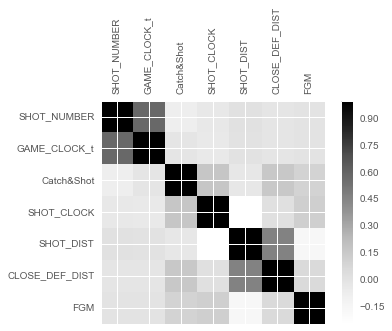

In [7]:
# Correlation heatmap
list(corr.columns)
figure = plt.figure()
subplot = figure.add_subplot(1, 1, 1)
figure.colorbar(subplot.matshow(corr))
subplot.set_xticklabels([None] + list(corr.columns), rotation = 90)
subplot.set_yticklabels([None] + list(corr.columns))

## Modeling

In [8]:
train_y = train_2_df.FGM
test_y = test_2_df.FGM

#### Guessing the Majority Class

Train Result

In [9]:
# predict all missed shots
train_2_df['model_1_y_hat']=0

In [10]:
#Confusion Matrix
pd.crosstab(train_y, train_2_df.model_1_y_hat, rownames = ['True Class'], colnames = ['Hypothesized Class'])

Hypothesized Class,0
True Class,
0,27865
1,26646


In [11]:
#Null accuracy rate
27647./(26558+27647)

0.5100451987824002

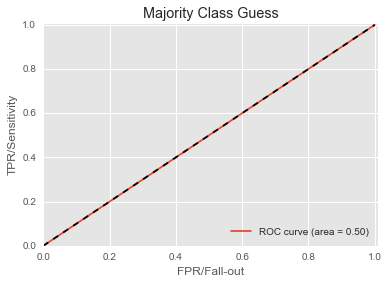

In [12]:
#ROC
fpr, tpr, thresholds = metrics.roc_curve(train_y, train_2_df.model_1_y_hat)

plt.figure()
plt.plot(fpr, tpr, label = 'ROC curve (area = %0.2f)' % metrics.auc(fpr, tpr))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0, 1.01])
plt.ylim([0, 1.01])
plt.xlabel('FPR/Fall-out')
plt.ylabel('TPR/Sensitivity')
plt.title("Majority Class Guess")
plt.legend(loc = 'lower right')
plt.show()

Test Result

In [13]:
test_2_df['model_1_y_hat']=0

In [14]:
pd.crosstab(test_y, test_2_df.model_1_y_hat, rownames = ['True Class'], colnames = ['Hypothesized Class'])

Hypothesized Class,0
True Class,
0,18370
1,17764


In [15]:
#Null accuracy rate
18519./(17822+18519)

0.5095897196004513

#### Logistic Regression

In [16]:
#Logistic 1: all significant features
train_X = train_2_df[['SHOT_NUMBER','GAME_CLOCK_t','Catch&Shot','SHOT_CLOCK','SHOT_DIST','CLOSE_DEF_DIST']]

In [17]:
logit = linear_model.LogisticRegression().\
    fit(train_X, train_y)

In [18]:
print logit.coef_
print logit.intercept_

[[  5.81183507e-03  -2.40008728e-05   2.19927692e-01   1.79643147e-02
   -7.34469989e-02   1.59836586e-01]]
[-0.20312466]


In [19]:
# Confusion matrix
pd.crosstab(train_y, logit.predict(train_X), rownames = ['True Class'], colnames = ['Hypothesized Class'])

Hypothesized Class,0,1
True Class,,
0,17932,9933
1,11776,14870


In [20]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(2)
    plt.xticks(tick_marks)
    plt.yticks(tick_marks)
    plt.tight_layout()
    plt.ylabel('Predicted label')
    plt.xlabel('True label')

In [21]:
def confusion_matrix_cal(cm):
    print "Accuracy =", metrics.accuracy_score(train_y,logit.predict(train_X))
    print "True positive rate =", float(cm[1][1])/(cm[1][0]+cm[1][1])
    print "False positive rate =", float(cm[0][1])/(cm[0][1]+cm[0][0])
    print "Specificity =", float(cm[0][0])/(cm[0][0]+cm[0][1])
    print "Precision", float(cm[1][1])/(cm[0][1]+cm[1][1])
    print "Improvement compared to null error rate =", metrics.accuracy_score(train_y,logit.predict(train_X))- 27647./(26558+27647)

Normalized confusion matrix
[[ 0.64353131  0.35646869]
 [ 0.44194251  0.55805749]]


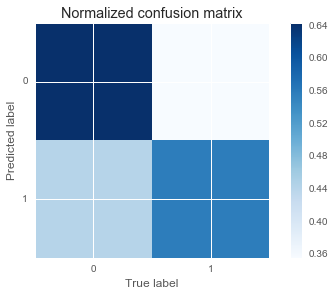

In [22]:
cm = metrics.confusion_matrix(train_y,logit.predict(train_X))
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print('Normalized confusion matrix')
print(cm_normalized)
plt.figure()
plot_confusion_matrix(cm_normalized, title='Normalized confusion matrix')

plt.show()

In [23]:
#Confusion matrix metrics:
confusion_matrix_cal(cm)

Accuracy = 0.601750105483
True positive rate = 0.558057494558
False positive rate = 0.356468688319
Specificity = 0.643531311681
Precision 0.599524251099
Improvement compared to null error rate = 0.0917049067009


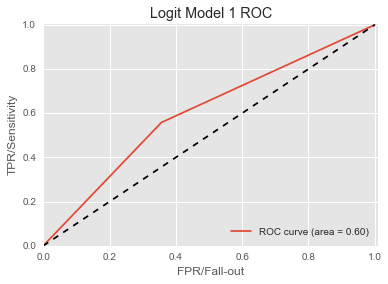

In [24]:
#ROC
fpr, tpr, thresholds = metrics.roc_curve(train_y, logit.predict(train_X))

plt.figure()
plt.plot(fpr, tpr, label = 'ROC curve (area = %0.2f)' % metrics.auc(fpr, tpr))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0, 1.01])
plt.ylim([0, 1.01])
plt.xlabel('FPR/Fall-out')
plt.ylabel('TPR/Sensitivity')
plt.title("Logit Model 1 ROC")
plt.legend(loc = 'lower right')
plt.show()

In [25]:
#10 - fold CV
cross_validation.cross_val_score(logit, train_X, train_y, cv = 10).mean()

0.60169550572253017

In [175]:
#Logistic 2: Only Shot Distance, Closest Defender and Catch&Shot
train_X = train_2_df[['Catch&Shot','SHOT_DIST','CLOSE_DEF_DIST']]

In [176]:
logit = linear_model.LogisticRegression().\
    fit(train_X, train_y)

In [177]:
print logit.coef_
print logit.intercept_

[[ 0.24630496 -0.07796142  0.16546286]]
[ 0.03948843]


In [178]:
# Accuracy for 
logit.score(train_X, train_y)

0.60046596099869753

In [30]:
pd.crosstab(train_y, logit.predict(train_X), rownames = ['Hypothesized Class'], colnames = ['True Class'])

True Class,0,1
Hypothesized Class,,
0,17702,10163
1,11616,15030


Normalized confusion matrix
[[ 0.63527723  0.36472277]
 [ 0.43593785  0.56406215]]


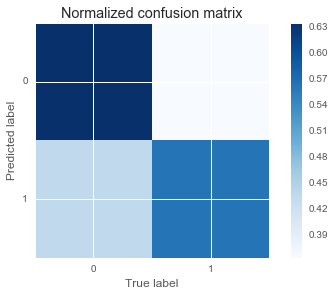

In [31]:
cm = metrics.confusion_matrix(train_y,logit.predict(train_X))
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print('Normalized confusion matrix')
print(cm_normalized)
plt.figure()
plot_confusion_matrix(cm_normalized, title='Normalized confusion matrix')

plt.show()

In [32]:
confusion_matrix_cal(cm)

Accuracy = 0.600465960999
True positive rate = 0.564062148165
False positive rate = 0.364722770501
Specificity = 0.635277229499
Precision 0.596594292065
Improvement compared to null error rate = 0.0904207622163


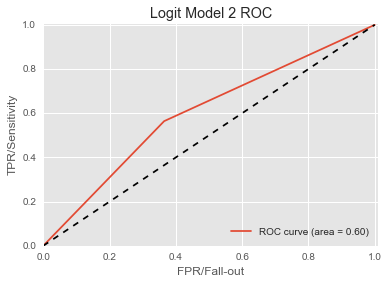

In [33]:
#ROC
fpr, tpr, thresholds = metrics.roc_curve(train_y, logit.predict(train_X))

plt.figure()
plt.plot(fpr, tpr, label = 'ROC curve (area = %0.2f)' % metrics.auc(fpr, tpr))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0, 1.01])
plt.ylim([0, 1.01])
plt.xlabel('FPR/Fall-out')
plt.ylabel('TPR/Sensitivity')
plt.title("Logit Model 2 ROC")
plt.legend(loc = 'lower right')
plt.show()

In [34]:
#10 - fold CV
cross_validation.cross_val_score(logit, train_X, train_y, cv = 10).mean()

0.60020961721073152

In [35]:
#Logistic 3: Only Shot Distance
train_X = train_2_df[['SHOT_DIST']]

In [36]:
logit = linear_model.LogisticRegression().\
    fit(train_X, train_y)

In [37]:
print logit.coef_
print logit.intercept_

[[-0.0503703]]
[ 0.43775656]


In [38]:
pd.crosstab(train_y, logit.predict(train_X), rownames = ['Hypothesized Class'], colnames = ['True Class'])

True Class,0,1
Hypothesized Class,,
0,14521,13344
1,9843,16803


Normalized confusion matrix
[[ 0.52111968  0.47888032]
 [ 0.36939878  0.63060122]]


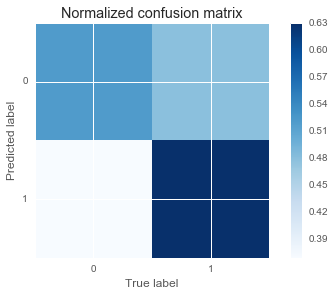

In [39]:
cm = metrics.confusion_matrix(train_y,logit.predict(train_X))
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print('Normalized confusion matrix')
print(cm_normalized)
plt.figure()
plot_confusion_matrix(cm_normalized, title='Normalized confusion matrix')

plt.show()

In [40]:
confusion_matrix_cal(cm)

Accuracy = 0.574636311937
True positive rate = 0.630601215942
False positive rate = 0.478880315808
Specificity = 0.521119684192
Precision 0.557368892427
Improvement compared to null error rate = 0.0645911131546


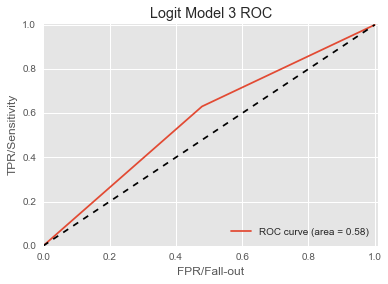

In [41]:
#ROC
fpr, tpr, thresholds = metrics.roc_curve(train_y, logit.predict(train_X))

plt.figure()
plt.plot(fpr, tpr, label = 'ROC curve (area = %0.2f)' % metrics.auc(fpr, tpr))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0, 1.01])
plt.ylim([0, 1.01])
plt.xlabel('FPR/Fall-out')
plt.ylabel('TPR/Sensitivity')
plt.title("Logit Model 3 ROC")
plt.legend(loc = 'lower right')
plt.show()

In [42]:
#10 - fold CV
cross_validation.cross_val_score(logit, train_X, train_y, cv = 10).mean()

0.57445313367748008

In [43]:
#Logistic 4: Only Shot Distance and Catch%Shot
train_X = train_2_df[['SHOT_DIST','Catch&Shot']]

In [44]:
logit = linear_model.LogisticRegression().\
    fit(train_X, train_y)

In [45]:
print logit.coef_
print logit.intercept_

[[-0.04988438  0.37630108]]
[ 0.28416732]


In [46]:
# Accuracy for 
logit.score(train_X, train_y)

0.59032121957036199

In [47]:
pd.crosstab(train_y, logit.predict(train_X), rownames = ['Hypothesized Class'], colnames = ['True Class'])

True Class,0,1
Hypothesized Class,,
0,17535,10330
1,12002,14644


Normalized confusion matrix
[[ 0.62928405  0.37071595]
 [ 0.45042408  0.54957592]]


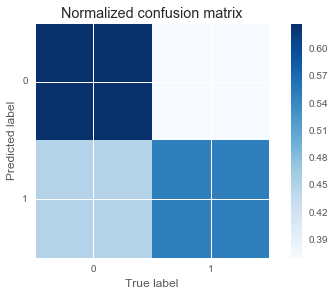

In [48]:
cm = metrics.confusion_matrix(train_y,logit.predict(train_X))
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print('Normalized confusion matrix')
print(cm_normalized)
plt.figure()
plot_confusion_matrix(cm_normalized, title='Normalized confusion matrix')

plt.show()

In [49]:
confusion_matrix_cal(cm)

Accuracy = 0.59032121957
True positive rate = 0.549575921339
False positive rate = 0.370715951911
Specificity = 0.629284048089
Precision 0.586369824618
Improvement compared to null error rate = 0.080276020788


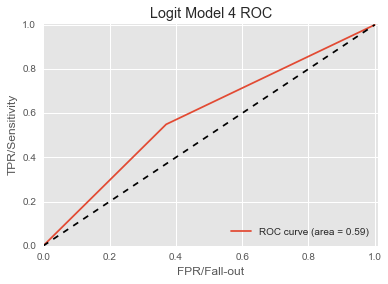

In [50]:
#ROC
fpr, tpr, thresholds = metrics.roc_curve(train_y, logit.predict(train_X))

plt.figure()
plt.plot(fpr, tpr, label = 'ROC curve (area = %0.2f)' % metrics.auc(fpr, tpr))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0, 1.01])
plt.ylim([0, 1.01])
plt.xlabel('FPR/Fall-out')
plt.ylabel('TPR/Sensitivity')
plt.title("Logit Model 4 ROC")
plt.legend(loc = 'lower right')
plt.show()

In [51]:
#10 - fold CV
cross_validation.cross_val_score(logit, train_X, train_y, cv = 10).mean()

0.5899361917664403

In [52]:
#Logistic 5: Only Shot Distance and Closest Defender
train_X = train_2_df[['SHOT_DIST','CLOSE_DEF_DIST']]

In [53]:
logit = linear_model.LogisticRegression().\
    fit(train_X, train_y)

In [54]:
print logit.coef_
print logit.intercept_

[[-0.08099588  0.18114361]]
[ 0.11336785]


In [55]:
# Accuracy for 
logit.score(train_X, train_y)

0.59402689365449179

In [56]:
pd.crosstab(train_y, logit.predict(train_X), rownames = ['Hypothesized Class'], colnames = ['True Class'])

True Class,0,1
Hypothesized Class,,
0,17035,10830
1,11300,15346


Normalized confusion matrix
[[ 0.61134039  0.38865961]
 [ 0.42407866  0.57592134]]


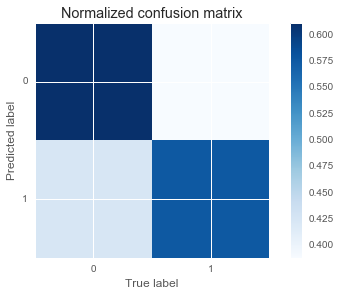

In [57]:
cm = metrics.confusion_matrix(train_y,logit.predict(train_X))
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print('Normalized confusion matrix')
print(cm_normalized)
plt.figure()
plot_confusion_matrix(cm_normalized, title='Normalized confusion matrix')

plt.show()

In [58]:
confusion_matrix_cal(cm)

Accuracy = 0.594026893654
True positive rate = 0.575921339038
False positive rate = 0.388659608828
Specificity = 0.611340391172
Precision 0.586262224939
Improvement compared to null error rate = 0.0839816948721


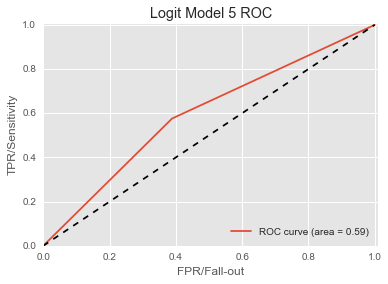

In [59]:
#ROC
fpr, tpr, thresholds = metrics.roc_curve(train_y, logit.predict(train_X))

plt.figure()
plt.plot(fpr, tpr, label = 'ROC curve (area = %0.2f)' % metrics.auc(fpr, tpr))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0, 1.01])
plt.ylim([0, 1.01])
plt.xlabel('FPR/Fall-out')
plt.ylabel('TPR/Sensitivity')
plt.title("Logit Model 5 ROC")
plt.legend(loc = 'lower right')
plt.show()

In [60]:
# 10 fold CV
cross_validation.cross_val_score(logit, train_X, train_y, cv = 10).mean()

0.59411897460195151

#### Logistic Model Compare

Metrics| Logit_1 | Logit_2 | Logit_3 | Logit_4 | Logit_5
---|---|---
Accuracy | 0.6012729453	 | 0.600110690896 | 0.589631952772 |0.589631952772| 0.594465455216
True positive rate | 0.559567738535 | 0.56502748701 |0.632690714662|0.551396942541|0.576737706153
False positive rate | 0.358664592903 | 0.366188013166 |0.482656346077|0.373639092849|0.388505081926
Specificity | 0.641335407097 | 0.633811986834 |0.517343653923|0.626360907151|0.611494918074
Precision | 0.599790127941 | 0.597134898528 |0.557368892427|0.586369824618|0.58780412925
Improvement | 0.0912277465178 | 0.0900654921133 |0.063813301356|0.0795867539895|0.0844202564339

From comparing Logistic Model 1 and 2, the improvement of including all variables are not significant. For simplicity, logistic model 2 performed is better since it only includes the 3 most significant variables. When compared logistic model 2 to others (3, 4 and 5), it kind of depends on which metrics we want to optimize.

#### KNN

In [190]:
KNN_train_df = train_2_df[['Catch&Shot','SHOT_DIST','CLOSE_DEF_DIST']]

In [191]:
KNN_test_df = test_2_df[['Catch&Shot','SHOT_DIST','CLOSE_DEF_DIST']]

In [192]:
# Variable Scaling
def variable_scale(x):
    s = pd.Series(data, index=index)
    for n in len(x):
        (x[n]-x.min())/(x.max()-x.min())
        

In [193]:
# Scaling for both training and testingf
for n in range(1,3):
    KNN_train_df[KNN_train_df.columns[n]] = \
        (KNN_train_df[KNN_train_df.columns[n]]-KNN_train_df[KNN_train_df.columns[n]].min())\
        /(KNN_train_df[KNN_train_df.columns[n]].max()-KNN_train_df[KNN_train_df.columns[n]].min())
for n in range(1,3):
    KNN_test_df[KNN_test_df.columns[n]] = \
        (KNN_test_df[KNN_test_df.columns[n]]-KNN_test_df[KNN_test_df.columns[n]].min())\
        /(KNN_test_df[KNN_test_df.columns[n]].max()-KNN_test_df[KNN_test_df.columns[n]].min())    

/Users/gyzhang328/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/Users/gyzhang328/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [194]:
KNN_test_df.head(2)

,Catch&Shot,SHOT_DIST,CLOSE_DEF_DIST
0,0,0.156118,0.020677
1,0,0.873418,0.114662


In [195]:
KNN_train_df.head(2)

,Catch&Shot,SHOT_DIST,CLOSE_DEF_DIST
0,1,0.108545,0.062382
1,0,0.154734,0.032136


In [196]:
train_X = KNN_train_df
KNN_model = neighbors.KNeighborsClassifier(n_neighbors = 3, weights = 'uniform')
KNN_model.fit(train_X, train_y)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=3, p=2,
           weights='uniform')

In [197]:
KNN_model.score(train_X, train_y)

0.70831575278384185

In [ ]:
k = range(1, 50)

score_df = pd.DataFrame({'k': k})

models = score_df.\
    apply(lambda row: neighbors.KNeighborsClassifier(n_neighbors = row['k'], weights = 'uniform').fit(train_X, train_y), axis = 1)

models

score_df['Score'] = models.map(lambda model: model.score(train_X, train_y))

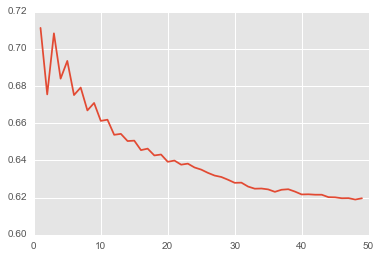

In [70]:
plt.plot(score_df.k, score_df.Score)

In [71]:
score_df[score_df.Score ==score_df.Score.max()]

,k,Score
0,1,0.711233


Normalized confusion matrix
[[ 0.72115557  0.27884443]
 [ 0.30511146  0.69488854]]


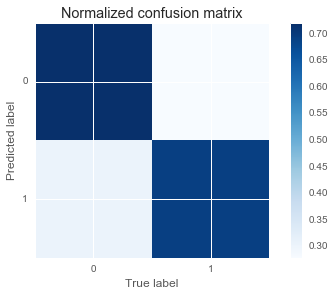

In [72]:
cm = metrics.confusion_matrix(train_y,KNN_model.predict(train_X))
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print('Normalized confusion matrix')
print(cm_normalized)
plt.figure()
plot_confusion_matrix(cm_normalized, title='Normalized confusion matrix')

plt.show()

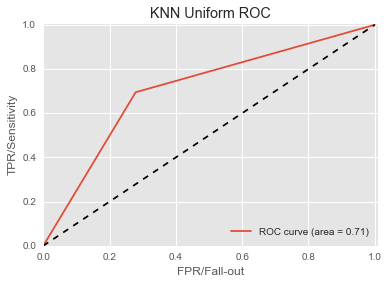

In [73]:
#ROC
fpr, tpr, thresholds = metrics.roc_curve(train_y, KNN_model.predict(train_X))

plt.figure()
plt.plot(fpr, tpr, label = 'ROC curve (area = %0.2f)' % metrics.auc(fpr, tpr))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0, 1.01])
plt.ylim([0, 1.01])
plt.xlabel('FPR/Fall-out')
plt.ylabel('TPR/Sensitivity')
plt.title("KNN Uniform ROC")
plt.legend(loc = 'lower right')
plt.show()

In [74]:
train_X = KNN_train_df
KNN_model = neighbors.KNeighborsClassifier(n_neighbors = 10, weights = 'distance')
KNN_model.fit(train_X, train_y)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=10, p=2,
           weights='distance')

In [75]:
k = range(1, 50)

score_df = pd.DataFrame({'k': k})

models = score_df.\
    apply(lambda row: neighbors.KNeighborsClassifier(n_neighbors = row['k'], weights = 'distance').fit(train_X, train_y), axis = 1)

models

score_df['Score'] = models.map(lambda model: model.score(train_X, train_y))

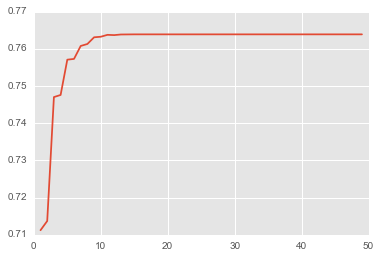

In [76]:
plt.plot(score_df.k, score_df.Score)

In [188]:
KNN_model = neighbors.KNeighborsClassifier(n_neighbors = 1, weights = 'uniform')
KNN_model.fit(train_X, train_y)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=1, p=2,
           weights='uniform')

In [161]:
cross_validation.cross_val_score(KNN_model, train_X, train_y, cv = 10).mean()

0.52749001285770825

In [77]:
score_df[score_df.Score ==score_df.Score.max()].min()

k        15.000000
Score     0.763883
dtype: float64

Normalized confusion matrix
[[ 0.85989593  0.14010407]
 [ 0.33783682  0.66216318]]


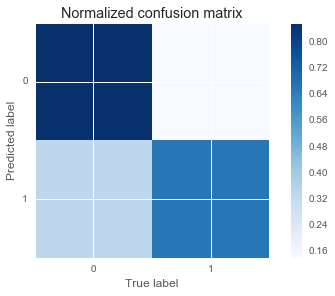

In [78]:
cm = metrics.confusion_matrix(train_y,KNN_model.predict(train_X))
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print('Normalized confusion matrix')
print(cm_normalized)
plt.figure()
plot_confusion_matrix(cm_normalized, title='Normalized confusion matrix')

plt.show()

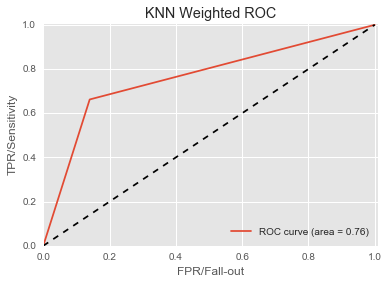

In [79]:
#ROC
fpr, tpr, thresholds = metrics.roc_curve(train_y, KNN_model.predict(train_X))

plt.figure()
plt.plot(fpr, tpr, label = 'ROC curve (area = %0.2f)' % metrics.auc(fpr, tpr))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0, 1.01])
plt.ylim([0, 1.01])
plt.xlabel('FPR/Fall-out')
plt.ylabel('TPR/Sensitivity')
plt.title("KNN Weighted ROC")
plt.legend(loc = 'lower right')
plt.show()

In [199]:
KNN_model = neighbors.KNeighborsClassifier(n_neighbors = 15, weights = 'distance')
KNN_model.fit(train_X, train_y)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=15, p=2,
           weights='distance')

In [201]:
cross_validation.cross_val_score(KNN_model, train_X, train_y, cv = 10).mean()

0.55814424953209552

KNN Summary: Seems like the best KNN model is k=1 for uniform model and k=15 for distance weighted model.

#### Random Forest

In [80]:
train_X =  train_2_df[['SHOT_NUMBER','GAME_CLOCK_t','Catch&Shot','SHOT_CLOCK','SHOT_DIST','CLOSE_DEF_DIST']]

In [81]:
train_X.head(2)

,SHOT_NUMBER,GAME_CLOCK_t,Catch&Shot,SHOT_CLOCK,SHOT_DIST,CLOSE_DEF_DIST
0,7,2031.0,1,8.6,4.7,3.3
1,5,1392.0,0,12.9,6.7,1.7


In [166]:
# 10K trees
random_forest_1 = ensemble.RandomForestClassifier(n_estimators = 100,
        max_features = 3,
        min_samples_leaf = 5,
        oob_score = True,
        random_state = 0).\
    fit(train_X, train_y)

In [167]:
random_forest_1.oob_score_

0.5851662967107556

In [168]:
random_forest_1.score(train_X, train_y)

0.91363211095008345

In [169]:
test_X = test_2_df[['SHOT_NUMBER','GAME_CLOCK_t','Catch&Shot','SHOT_CLOCK','SHOT_DIST','CLOSE_DEF_DIST']]

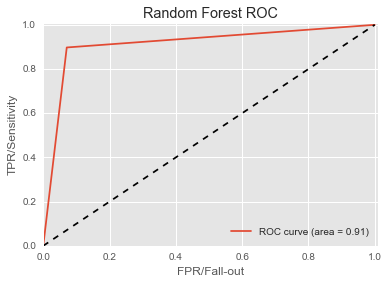

In [171]:
#ROC
fpr, tpr, thresholds = metrics.roc_curve(train_y, random_forest_1.predict(train_X))

plt.figure()
plt.plot(fpr, tpr, label = 'ROC curve (area = %0.2f)' % metrics.auc(fpr, tpr))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0, 1.01])
plt.ylim([0, 1.01])
plt.xlabel('FPR/Fall-out')
plt.ylabel('TPR/Sensitivity')
plt.title("Random Forest ROC")
plt.legend(loc = 'lower right')
plt.show()

In [172]:
cross_validation.cross_val_score(random_forest_1, train_X, train_y, cv = 10).mean()

0.58747800791549465

Test Result

In [173]:
# Model 1
pd.crosstab(test_y, test_2_df.model_1_y_hat, rownames = ['True Class'], colnames = ['Hypothesized Class'])

Hypothesized Class,0
True Class,
0,18370
1,17764


In [174]:
18370./(18370+17764)

0.5083854541429125

In [180]:
# Logistic Model
test_X = test_2_df[['Catch&Shot','SHOT_DIST','CLOSE_DEF_DIST']]
logit.score(test_X, test_y)

0.59520119554989759

In [202]:
# KNN
KNN_model.score(KNN_test_df,test_y)

0.56827364808767367

In [186]:
#random_forest
test_X = test_2_df[['SHOT_NUMBER','GAME_CLOCK_t','Catch&Shot','SHOT_CLOCK','SHOT_DIST','CLOSE_DEF_DIST']]
random_forest_1.score(test_X, test_y)

0.58540432833342559

A deeper look at Logistic Model Test Result

In [203]:
# Logistic Model
test_X = test_2_df[['Catch&Shot','SHOT_DIST','CLOSE_DEF_DIST']]
logit.score(test_X, test_y)

0.59520119554989759

In [209]:
logit_y_hat = logit.predict(test_X)

In [210]:
logit_y_hat

array([0, 0, 1, ..., 1, 1, 0])

In [212]:
logit_y_hat_proba = logit.predict_proba(test_X)

In [213]:
logit_y_hat_proba

array([[ 0.51673367,  0.48326633],
       [ 0.63760625,  0.36239375],
       [ 0.38390277,  0.61609723],
       ..., 
       [ 0.4611712 ,  0.5388288 ],
       [ 0.47701888,  0.52298112],
       [ 0.70905876,  0.29094124]])

In [214]:
logit_y_hat = pd.Series(logit_y_hat)

In [216]:
logit_y_hat_proba = pd.DataFrame(logit_y_hat_proba)

In [218]:
logit_y_hat_proba['logit_y_hat'] = logit_y_hat

In [225]:
logit_y_hat_proba.rename(columns = {0:'missed_proba',1:'made_proba','logit_y_hat':'prediction'}, inplace = True) 

In [279]:
logit_y_hat_proba.head(2)

,missed_proba,made_proba,prediction
0,0.516734,0.483266,0
1,0.637606,0.362394,0


In [229]:
test_2_df = test_2_df.join(logit_y_hat_proba)

In [233]:
test_2_df['right'] = 0
test_2_df.at[test_2_df['FGM'] == test_2_df['prediction'],'right'] = 1

In [234]:
color = test_2_df.right.map(pd.Series({0: 'red', 1: 'green'}))

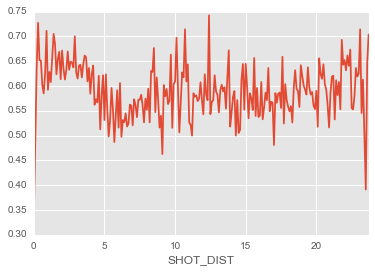

In [238]:
test_2_df.groupby('SHOT_DIST')['right'].mean().plot()

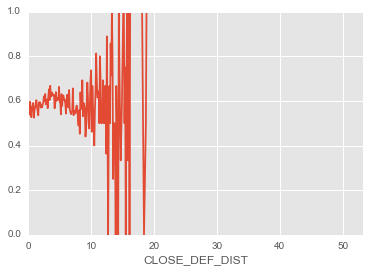

In [243]:
test_2_df.groupby('CLOSE_DEF_DIST')['right'].mean().plot()

In [262]:
# SHOT DISTANCE transformation of visualizations
def sd_transform(sd):
    n=2
    if sd>20:
        sd_t = '20+'
    elif sd<=2:
        sd_t = 2
    elif sd<=4:
        sd_t = 4
    elif sd<=6:
        sd_t = 6
    elif sd<=8:
        sd_t = 8
    elif sd<=10:
        sd_t = 10
    elif sd<=12:
        sd_t = 12
    elif sd<=14:
        sd_t = 14
    elif sd<=16:
        sd_t = 16
    elif sd<=18:
        sd_t = 18
    else:
        sd_t = 20
    return sd_t

In [263]:
def cd_transform(sd):
    n=2
    if sd>10:
        sd_t = '10+'
    elif sd<=1:
        sd_t = 1
    elif sd<=2:
        sd_t = 2
    elif sd<=3:
        sd_t = 3
    elif sd<=4:
        sd_t = 4
    elif sd<=5:
        sd_t = 5
    elif sd<=6:
        sd_t = 6
    elif sd<=7:
        sd_t = 7
    elif sd<=8:
        sd_t = 8
    elif sd<=9:
        sd_t = 9
    else:
        sd_t = 10
    return sd_t

In [264]:
test_2_df['SHOT_DISTANCE'] = test_2_df.SHOT_DIST.apply(sd_transform)
test_2_df['CLOSEST_DEFENDER_DISTANE'] = test_2_df.CLOSE_DEF_DIST.apply(cd_transform)

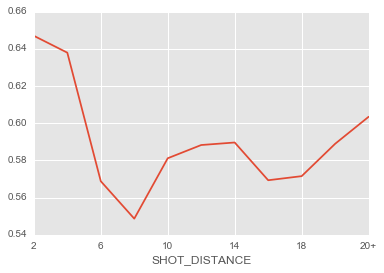

In [265]:
test_2_df.groupby('SHOT_DISTANCE')['right'].mean().plot()

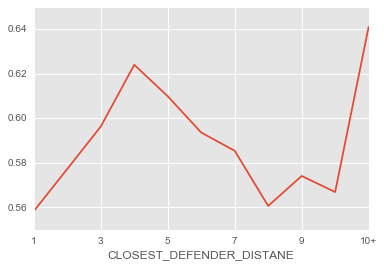

In [268]:
test_2_df.groupby('CLOSEST_DEFENDER_DISTANE')['right'].mean().plot()

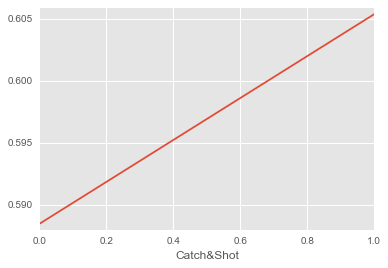

In [269]:
test_2_df.groupby('Catch&Shot')['right'].mean().plot()

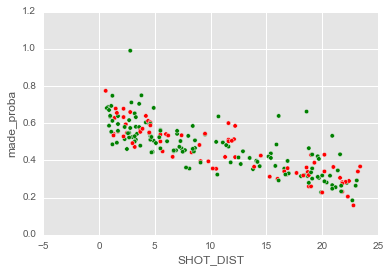

In [280]:
test_2_df[test_2_df.player_name == 'stephen curry'].plot('SHOT_DIST', 'made_proba', kind = 'scatter', c = color)

In [292]:
test_2_df[test_2_df.player_name == 'stephen curry']['FGM'].mean()

0.5555555555555556

In [293]:
test_2_df[test_2_df.player_name == 'stephen curry']['made_proba'].mean()

0.46456365336939115

In [302]:
test_2_df[test_2_df.player_name == 'russell westbrook']['FGM'].mean()

0.4778481012658228

In [303]:
test_2_df[test_2_df.player_name == 'russell westbrook']['made_proba'].mean()

0.4482143501397718

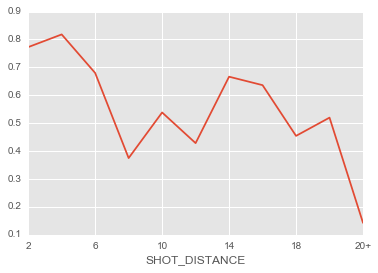

In [309]:
test_2_df[test_2_df.player_name == 'stephen curry'].groupby('SHOT_DISTANCE')['FGM'].mean().plot()

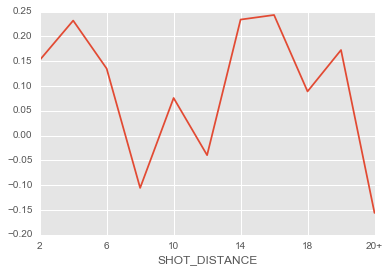

In [311]:
(test_2_df[test_2_df.player_name == 'stephen curry'].groupby('SHOT_DISTANCE')['FGM'].mean()-test_2_df[test_2_df.player_name == 'stephen curry'].groupby('SHOT_DISTANCE')['made_proba'].mean()).plot()

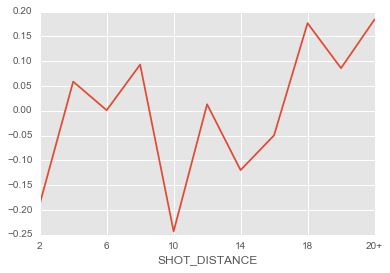

In [312]:
(test_2_df[test_2_df.player_name == 'russell westbrook'].groupby('SHOT_DISTANCE')['FGM'].mean()-test_2_df[test_2_df.player_name == 'russell westbrook'].groupby('SHOT_DISTANCE')['made_proba'].mean()).plot()